<a href="https://colab.research.google.com/github/8bitnand/Blogs/blob/main/GPU_Accelerated_Data_Science_with_Pandas_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## GPU Accelerated Data Science with Pandas
---

Let's compare the performance of pandas with **cpu** and **gpu acceleration** on [MovieLens 25M Dataset](https://grouplens.org/datasets/movielens/25m/) data set.

This is a fairly big dataset for starters.

**Prerequisites** -

* If you are working in Google collab I have given all the setup below
* For other systems please go through [quick-start](https://rapids.ai/#quick-start) provided by rapids


In [ ]:
# make sure you enable GPU runtime
!nvidia-smi

Sun Dec 24 11:21:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Install dependencies and import pandas and cudf

In [ ]:
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com -q
!pip install plotly-express -q

In [ ]:
import cudf

Download the MovieLens 25M Dataset, unzip to a folder

We will use just the ratings.csv and movies.csv files




In [ ]:
# !wget https://files.grouplens.org/datasets/movielens/ml-25m.zip
# ! unzip -y /content/ml-25m.zip -d .

### Analysis using Standard Pandas

First, let's use Pandas to read in some columns of the dataset:

In [ ]:
import pandas as pd

In [ ]:
%%time
ratings_df = pd.read_csv(
    "/content/ml-25m/ratings.csv",
    )
ratings_df.sample(10)

CPU times: user 9.63 s, sys: 1.22 s, total: 10.9 s
Wall time: 10.9 s


,userId,movieId,rating,timestamp
22778351,148061,63992,3.5,1236435778
2454605,16377,49276,3.5,1551987044
22532900,146475,6503,2.5,1465846234
5728780,37088,173,3.0,841844243
4486719,29486,186,3.0,1489885807
6367376,41304,74458,3.5,1530456270
22823351,148305,1191,2.0,1019620760
7855221,51032,4016,4.5,1539141854
6906190,44802,969,3.0,938559619
14216076,92056,4130,2.0,1017013569


In [ ]:
%time
movies_df = pd.read_csv("/content/ml-25m/movies.csv")
movies_df.head(5)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
len(ratings_df), len(movies_df)

(25000095, 62423)

Let's get the most rated and highest rated moves by average

In [ ]:
%%time
ratings_grouped = ratings_df.groupby('movieId').agg({'userId': 'count', 'rating': 'mean'})
ratings_grouped = ratings_grouped.rename(columns={'userId': 'num_users', 'rating': 'avg_rating'})
ratings_grouped = ratings_grouped.reset_index()

ratings_grouped.head()

CPU times: user 733 ms, sys: 99.8 ms, total: 833 ms
Wall time: 826 ms


,movieId,num_users,avg_rating
0,1,57309,3.893708
1,2,24228,3.251527
2,3,11804,3.142028
3,4,2523,2.853547
4,5,11714,3.058434


In [ ]:
%%time
movelens_df = pd.merge(ratings_grouped, movies_df, on='movieId')
movelens_df.head()

CPU times: user 19.1 ms, sys: 132 µs, total: 19.2 ms
Wall time: 18.8 ms


,movieId,num_users,avg_rating,title,genres
0,1,57309,3.893708,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,24228,3.251527,Jumanji (1995),Adventure|Children|Fantasy
2,3,11804,3.142028,Grumpier Old Men (1995),Comedy|Romance
3,4,2523,2.853547,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,11714,3.058434,Father of the Bride Part II (1995),Comedy


Let's see the top rated movie

In [ ]:
%%time
movelens_df = movelens_df.sort_values(by=['avg_rating', 'num_users'], ascending=[False, False ])
movelens_df.head()

CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 22.4 ms


,movieId,num_users,avg_rating,title,genres
23235,118268,3,5.0,Borrowed Time (2012),Drama
33976,148298,3,5.0,Awaken (2013),Drama|Romance|Sci-Fi
40729,165787,3,5.0,Lonesome Dove Church (2014),Western
46900,179731,3,5.0,Sound of Christmas (2016),Drama
28113,133297,2,5.0,Genius on Hold (2013),(no genres listed)


In [ ]:
%%time
movelens_df = movelens_df.sort_values(by=['num_users', 'avg_rating'], ascending=[False, False])
movelens_df.head()

CPU times: user 15.7 ms, sys: 970 µs, total: 16.7 ms
Wall time: 16.6 ms


,movieId,num_users,avg_rating,title,genres
351,356,81491,4.048011,Forrest Gump (1994),Comedy|Drama|Romance|War
314,318,81482,4.413576,"Shawshank Redemption, The (1994)",Crime|Drama
292,296,79672,4.188912,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
585,593,74127,4.151342,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2480,2571,72674,4.154099,"Matrix, The (1999)",Action|Sci-Fi|Thriller


Apparently **81491** have rated **Forrest Gump (1994)**  movie which is the most rated movie and top rated. We considered the ratings should also ve given by more people that way we are confident that the movie in general is good (if you are building a recommendation system). So we ignored **Borrowed Time (2012)**



### Using GPU accelerator

Now, let's re-run the Pandas code above with the `cudf.pandas` extension loaded.

Typically, you should load the `cudf.pandas` extension as the first step in your notebook, before importing any modules. Here, we explicitly restart the kernel to simulate that behavior.

In [ ]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

In [ ]:
%load_ext cudf.pandas

In [ ]:
import pandas as pd

In [ ]:
pd
# check if your cudf has been loaded

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

In [ ]:
%%time
ratings_df = pd.read_csv(
    "/content/ml-25m/ratings.csv",
    )
ratings_df.sample(10)

CPU times: user 696 ms, sys: 215 ms, total: 910 ms
Wall time: 978 ms


,userId,movieId,rating,timestamp
24989309,162505,339,3.0,840104659
5433979,35221,3825,1.0,1156978770
20269543,131761,59315,4.5,1399328176
1843075,12244,76091,4.0,1445039621
16251836,105382,2731,4.0,1465277508
13851960,89795,1373,4.0,974747624
12040040,78106,72998,2.5,1270019730
24036765,156190,2797,3.5,1494165482
24477684,159051,1682,3.0,1128039560
9473540,61594,500,4.0,1472061464


In [ ]:
%%time
movies_df = pd.read_csv("/content/ml-25m/movies.csv")
movies_df.head(5)

CPU times: user 15.6 ms, sys: 3.78 ms, total: 19.3 ms
Wall time: 21.8 ms


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
%%time
ratings_grouped = ratings_df.groupby('movieId').agg({'userId': 'count', 'rating': 'mean'})
ratings_grouped = ratings_grouped.rename(columns={'userId': 'num_users', 'rating': 'avg_rating'})
ratings_grouped = ratings_grouped.reset_index()

ratings_grouped.head()

CPU times: user 92.2 ms, sys: 37.6 ms, total: 130 ms
Wall time: 125 ms


,movieId,num_users,avg_rating
0,1,57309,3.893708
1,2,24228,3.251527
2,3,11804,3.142028
3,4,2523,2.853547
4,5,11714,3.058434


In [ ]:
%%time
movelens_df = pd.merge(ratings_grouped, movies_df, on='movieId')
movelens_df.head()

CPU times: user 10.5 ms, sys: 4.77 ms, total: 15.2 ms
Wall time: 13.9 ms


,movieId,num_users,avg_rating,title,genres
0,501,1923,3.842434,Naked (1993),Drama
1,502,3454,2.276491,"Next Karate Kid, The (1994)",Action|Children|Romance
2,503,131,3.095420,"New Age, The (1994)",Drama
3,504,1080,2.983796,No Escape (1994),Action|Drama|Sci-Fi
4,505,1224,2.502859,North (1994),Comedy


In [ ]:
%%time
movelens_df = movelens_df.sort_values(by=['num_users', 'avg_rating'], ascending=[False, False])
movelens_df.head()

CPU times: user 19.9 ms, sys: 7.18 ms, total: 27.1 ms
Wall time: 26 ms


,movieId,num_users,avg_rating,title,genres
7672,356,81491,4.048011,Forrest Gump (1994),Comedy|Drama|Romance|War
3001,318,81482,4.413576,"Shawshank Redemption, The (1994)",Crime|Drama
7277,296,79672,4.188912,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1944,593,74127,4.151342,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
8712,2571,72674,4.154099,"Matrix, The (1999)",Action|Sci-Fi|Thriller


As you saw it was a great improvement in speed expect for sorting

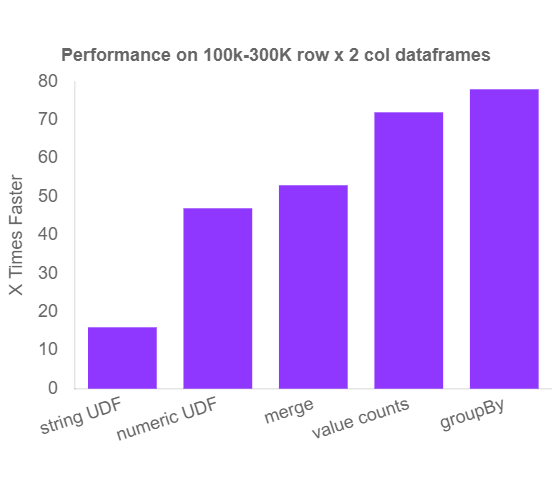

The above is the benchmarks provided by RAPIDS team

### Profiling
Lets see how much time each line takes to execute

In [ ]:
%%cudf.pandas.line_profile
ratings_df = pd.read_csv(
    "/content/ml-25m/ratings.csv",
    )
ratings_df.sample(10)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/cudf/pandas/profiler.py", line 97, in __enter__
    sys.settrace(self._tracefunc)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/cudf/pandas/profiler.py", line 116, in __exit__
    sys.settrace(self._oldtrace)



                                                                                 
                           Total time elapsed: 12.678 seconds                    
                                                                                 
                                          Stats                                  
                                                                                 
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Line no. ┃ Line                                   ┃ GPU TIME(s) ┃ CPU TIME(s) ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 1        │     ratings_df = pd.read_csv(          │             │             │
│          │                                        │             │             │
│ 2        │         "/content/ml-25m/ratings.csv", │             │             │
│          │                                        │             │             │
│ 4        │     ratings_df.sample(10)              │             │             │
│          │                                        │             │             │
└──────────┴────────────────────────────────────────┴─────────────┴─────────────┘

In [ ]:
len(ratings_df)

25000095

In [ ]:
%%cudf.pandas.line_profile

ratings_grouped = ratings_df.groupby('movieId').agg({'userId': 'count', 'rating': 'mean'})
ratings_grouped = ratings_grouped.rename(columns={'userId': 'num_users', 'rating': 'avg_rating'})
ratings_grouped = ratings_grouped.reset_index()

ratings_grouped.head()

                                                                                                                   
                                             Total time elapsed: 0.949 seconds                                     
                                                                                                                   
                                                           Stats                                                   
                                                                                                                   
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Line no. ┃ Line                                                                     ┃ GPU TIME(s) ┃ CPU TIME(s) ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 2        │     ratings_grouped = ratings_df.groupby('movieId').agg({'userId': 'cou… │ 0.032311832 │             │
│          │                                                                          │             │             │
│ 3        │     ratings_grouped = ratings_grouped.rename(columns={'userId': 'num_us… │ 0.003111027 │             │
│          │                                                                          │             │             │
│ 4        │     ratings_grouped = ratings_grouped.reset_index()                      │ 0.001178160 │             │
│          │                                                                          │             │             │
│ 6        │     ratings_grouped.head()                                               │ 0.003110005 │             │
│          │                                                                          │             │             │
└──────────┴──────────────────────────────────────────────────────────────────────────┴─────────────┴─────────────┘

For a column with **25000095** rows it took 0.032 sec to perform a groupby operation

I haven't gotten any info on how the accelerator works within code github from [cudf](https://github.com/rapidsai/cudf). May be next time 😁.